# Predicting Commodity Prices using Linear Regression in the Philippines
A **CS 180: Introduction to Artificial Intelligence** project that aims to develop a predictive **linear regression** model to accurately forecast commodity prices for future months and years using the **Philippine Food Prices Dataset**.

By Herminio Gregorio, Ali Jafri, and Ayen Manguan

**GitHub Repository:** https://github.com/NeoGregorio/commodity-predict  
**Slides:** https://www.canva.com/design/DAGHE9vcvzo/-FY5mjtsFpAB_ccoFxRXOQ/edit  
**Philippine Food Prices Dataset:** https://www.kaggle.com/datasets/usmanlovescode/philippines-food-prices-dataset  

## Preliminaries

First, import libraries and import our dataset. 

In [59]:
# @title Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import json
import joblib as jb     # Save and load models

In [60]:
# @title Load Dataset
data = pd.read_csv('wfp_food_prices_phl.csv')
data.head()

C:\Users\WINDOWS 10\AppData\Local\Temp\ipykernel_2208\278703577.py:2: DtypeWarning: Columns (4,5,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('wfp_food_prices_phl.csv')


,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,Maize flour (yellow),KG,actual,Retail,PHP,15.0,0.3717
2,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (milled, superior)",KG,actual,Retail,PHP,20.0,0.4957
3,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (milled, superior)",KG,actual,Wholesale,PHP,18.35,0.4548
4,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (regular, milled)",KG,actual,Wholesale,PHP,16.35,0.4052


Let's perform a bit of processing and take a quick look at our data.

In [61]:
# @title Drop Missing Values
data = data.dropna()

In [62]:
# @title Check shape and columns
data.shape
data.columns

Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'commodity', 'unit', 'priceflag', 'pricetype', 'currency',
       'price', 'usdprice'],
      dtype='object')

There are 121,513 rows and 14 columns of data in our dataset!

# Preprocessing

First, we ensure that our dataset is ready for analysis!

In [63]:
# @title Check information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121513 entries, 0 to 121512
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date       121513 non-null  object
 1   admin1     121513 non-null  object
 2   admin2     121513 non-null  object
 3   market     121513 non-null  object
 4   latitude   121513 non-null  object
 5   longitude  121513 non-null  object
 6   category   121513 non-null  object
 7   commodity  121513 non-null  object
 8   unit       121513 non-null  object
 9   priceflag  121513 non-null  object
 10  pricetype  121513 non-null  object
 11  currency   121513 non-null  object
 12  price      121513 non-null  object
 13  usdprice   121513 non-null  object
dtypes: object(14)
memory usage: 13.0+ MB


In [64]:
# @title Drop unnecessary columns
# `admin2` (province); `market` (city); latitude and longitude;
# `currency` (all in PHP anyway); `usdprice` (not included in analysis);
# unit (not included in analysis)

data.drop(['admin2', 'market', 'latitude',
           'longitude', 'currency', 'usdprice', 'unit'], axis=1, inplace=True)

data.head()

,date,admin1,category,commodity,priceflag,pricetype,price
0,#date,#adm1+name,#item+type,#item+name,#item+price+flag,#item+price+type,#value
1,2000-01-15,National Capital region,cereals and tubers,Maize flour (yellow),actual,Retail,15.0
2,2000-01-15,National Capital region,cereals and tubers,"Rice (milled, superior)",actual,Retail,20.0
3,2000-01-15,National Capital region,cereals and tubers,"Rice (milled, superior)",actual,Wholesale,18.35
4,2000-01-15,National Capital region,cereals and tubers,"Rice (regular, milled)",actual,Wholesale,16.35


In [65]:
# @title Remove first garbage row
data = data[1:]

In [66]:
# @title Rename region

# Map region to an integer value
le = LabelEncoder()
data['region'] = le.fit_transform(data['admin1'])
data = data.drop(['admin1'], axis=1)

region_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

region_mapping = {k: int(v) for k, v in zip(le.classes_, le.transform(le.classes_))}
print(region_mapping)

# Dump region_mapping to a JSON file
with open('app/region_mapping.json', 'w') as f:
    json.dump(region_mapping, f)
    
data

{'Autonomous region in Muslim Mindanao': 0, 'Cordillera Administrative region': 1, 'National Capital region': 2, 'Region I': 3, 'Region II': 4, 'Region III': 5, 'Region IV-A': 6, 'Region IV-B': 7, 'Region IX': 8, 'Region V': 9, 'Region VI': 10, 'Region VII': 11, 'Region VIII': 12, 'Region X': 13, 'Region XI': 14, 'Region XII': 15, 'Region XIII': 16}


,date,category,commodity,priceflag,pricetype,price,region
1,2000-01-15,cereals and tubers,Maize flour (yellow),actual,Retail,15.0,2
2,2000-01-15,cereals and tubers,"Rice (milled, superior)",actual,Retail,20.0,2
3,2000-01-15,cereals and tubers,"Rice (milled, superior)",actual,Wholesale,18.35,2
4,2000-01-15,cereals and tubers,"Rice (regular, milled)",actual,Wholesale,16.35,2
5,2000-01-15,cereals and tubers,"Rice (milled, superior)",actual,Retail,19.0,5
...,...,...,...,...,...,...,...
121508,2021-02-15,vegetables and fruits,Ginger,aggregate,Retail,114.0,16
121509,2021-02-15,vegetables and fruits,Mangoes (carabao),aggregate,Retail,106.67,16
121510,2021-02-15,vegetables and fruits,Onions (red),aggregate,Retail,114.17,16
121511,2021-02-15,vegetables and fruits,Papaya,aggregate,Retail,45.0,16


For categories, we can drop them since commodities will be used as input; we can save the mapping for future purpose.

In [67]:
# @title Drop category
category_commodity_mapping = data.groupby('category')['commodity'].apply(lambda x: list(set(x))).to_dict()

# Print the mapping
for category, commodities in category_commodity_mapping.items():
    print(f"{category}: {commodities}")

with open('app/category_commodity_mapping.json', 'w') as f:
    json.dump(category_commodity_mapping, f)

data = data.drop(['category'], axis=1)

cereals and tubers: ['Rice (paddy)', 'Maize (yellow)', 'Rice (milled, superior)', 'Rice (premium)', 'Maize (white)', 'Maize flour (white)', 'Rice (special)', 'Rice (well milled)', 'Taro', 'Maize flour (yellow)', 'Potatoes (Irish)', 'Sweet potatoes', 'Semolina (yellow)', 'Semolina (white)', 'Rice (regular, milled)']
meat, fish and eggs: ['Crab', 'Fish (milkfish)', 'Meat (beef)', 'Meat (pork, hock)', 'Chicken', 'Shrimp (tiger)', 'Anchovies', 'Meat (pork)', 'Fish (mackerel, fresh)', 'Meat (pork, with fat)', 'Fish (slipmouth)', 'Fish (tilapia)', 'Meat (chicken, whole)', 'Shrimp (endeavor)', 'Eggs (duck)', 'Fish (frigate tuna)', 'Meat (pork, with bones)', 'Fish (fresh)', 'Eggs', 'Fish (roundscad)', 'Meat (beef, chops with bones)', 'Fish (threadfin bream)', 'Fish (redbelly yellowtail fusilier)']
miscellaneous food: ['Sugar (brown)', 'Sugar (white)']
oil and fats: ['Oil (cooking)']
pulses and nuts: ['Groundnuts (shelled)', 'Beans (mung)', 'Groundnuts (unshelled)']
vegetables and fruits: ['Oni

Price is listed as objects, which is problematic for processing. 

In [68]:
# @title Convert datatypes
data['price'] = data['price'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121512 entries, 1 to 121512
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       121512 non-null  object 
 1   commodity  121512 non-null  object 
 2   priceflag  121512 non-null  object 
 3   pricetype  121512 non-null  object 
 4   price      121512 non-null  float64
 5   region     121512 non-null  int32  
dtypes: float64(1), int32(1), object(4)
memory usage: 5.1+ MB


We also process dates into own columns. This makes it easier for us to separate columns with different days, months, and years.

In [69]:
# @title Process date into own columns (year, month, day)
data['date'] = pd.to_datetime(data['date'])

# Distribute into own columns
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Drop raw date
data.drop('date', axis=1, inplace=True)

data.head()

,commodity,priceflag,pricetype,price,region,year,month,day
1,Maize flour (yellow),actual,Retail,15.00,2,2000,1,15
2,"Rice (milled, superior)",actual,Retail,20.00,2,2000,1,15
3,"Rice (milled, superior)",actual,Wholesale,18.35,2,2000,1,15
4,"Rice (regular, milled)",actual,Wholesale,16.35,2,2000,1,15
5,"Rice (milled, superior)",actual,Retail,19.00,5,2000,1,15


In [70]:
unique_days = data['day'].unique()
print("Unique values in 'day' column:", unique_days)

Unique values in 'day' column: [15]


Since days are all the same, we can drop it.

In [71]:
data = data.drop('day', axis=1)

Next, since linear regression cannot use categorical columns, we need to convert them to numerical ones. We can use one-hot encoding to create binary columns for each feature.

In [72]:
# Convert these columns into categorical
data = pd.get_dummies(data, columns=['priceflag', 'pricetype'])
column_order = data.columns.tolist()
print(column_order)

['commodity', 'price', 'region', 'year', 'month', 'priceflag_actual', 'priceflag_aggregate', 'pricetype_Farm Gate', 'pricetype_Retail', 'pricetype_Wholesale']


In [73]:
# Convert commodity variables to one-hot encoded variables
data_encoded = pd.get_dummies(data)
column_order = data_encoded.columns.tolist()
print(column_order)
data_encoded.info()

['price', 'region', 'year', 'month', 'priceflag_actual', 'priceflag_aggregate', 'pricetype_Farm Gate', 'pricetype_Retail', 'pricetype_Wholesale', 'commodity_Anchovies', 'commodity_Bananas (lakatan)', 'commodity_Bananas (latundan)', 'commodity_Bananas (saba)', 'commodity_Beans (green, fresh)', 'commodity_Beans (mung)', 'commodity_Beans (string)', 'commodity_Bitter melon', 'commodity_Bottle gourd', 'commodity_Cabbage', 'commodity_Cabbage (chinese)', 'commodity_Calamansi', 'commodity_Carrots', 'commodity_Chicken', 'commodity_Choko', 'commodity_Coconut', 'commodity_Crab', 'commodity_Eggplants', 'commodity_Eggs', 'commodity_Eggs (duck)', 'commodity_Fish (fresh)', 'commodity_Fish (frigate tuna)', 'commodity_Fish (mackerel, fresh)', 'commodity_Fish (milkfish)', 'commodity_Fish (redbelly yellowtail fusilier)', 'commodity_Fish (roundscad)', 'commodity_Fish (slipmouth)', 'commodity_Fish (threadfin bream)', 'commodity_Fish (tilapia)', 'commodity_Garlic', 'commodity_Garlic (large)', 'commodity_Gar

In [74]:
data.head()

,commodity,price,region,year,month,priceflag_actual,priceflag_aggregate,pricetype_Farm Gate,pricetype_Retail,pricetype_Wholesale
1,Maize flour (yellow),15.00,2,2000,1,True,False,False,True,False
2,"Rice (milled, superior)",20.00,2,2000,1,True,False,False,True,False
3,"Rice (milled, superior)",18.35,2,2000,1,True,False,False,False,True
4,"Rice (regular, milled)",16.35,2,2000,1,True,False,False,False,True
5,"Rice (milled, superior)",19.00,5,2000,1,True,False,False,True,False


# Data Exploration

Let us explore our data and figure out what is the best approach for our model.

First, let's still use the `data` dataframe. We use data_encoded later on.

In [75]:
# @title Check number of commodities and regions
num_unique_commodities = data['commodity'].nunique()
num_unique_regions = data['region'].nunique()
print(f"Commodities: {num_unique_commodities}; Regions: {num_unique_regions}")

Commodities: 73; Regions: 17


In [76]:
# @title Inspect commodity types
unique_commodities = data['commodity'].unique()
print(unique_commodities)

['Maize flour (yellow)' 'Rice (milled, superior)' 'Rice (regular, milled)'
 'Maize flour (white)' 'Meat (pork)' 'Maize (yellow)' 'Maize (white)'
 'Rice (paddy)' 'Cabbage' 'Carrots' 'Garlic' 'Tomatoes' 'Potatoes (Irish)'
 'Sweet potatoes' 'Fish (fresh)' 'Meat (beef, chops with bones)'
 'Meat (chicken, whole)' 'Onions (red)' 'Onions (white)' 'Eggs'
 'Beans (mung)' 'Groundnuts (unshelled)' 'Rice (premium)' 'Rice (special)'
 'Rice (well milled)' 'Taro' 'Anchovies' 'Crab' 'Fish (frigate tuna)'
 'Fish (mackerel, fresh)' 'Fish (roundscad)' 'Fish (slipmouth)'
 'Fish (threadfin bream)' 'Meat (beef)' 'Meat (pork, with bones)'
 'Shrimp (endeavor)' 'Groundnuts (shelled)' 'Bananas (latundan)'
 'Bananas (saba)' 'Beans (green, fresh)' 'Beans (string)' 'Bitter melon'
 'Bottle gourd' 'Cabbage (chinese)' 'Calamansi' 'Choko' 'Coconut'
 'Eggplants' 'Ginger' 'Papaya' 'Squashes' 'Sweet Potato leaves'
 'Water spinach' 'Semolina (white)' 'Semolina (yellow)' 'Eggs (duck)'
 'Fish (milkfish)' 'Fish (redbelly yel

Due to the large amount of commodities, is it possible to remove the subcategories? That is, treat `Fish (tilapia)` and `Fish (milkfish)` the same?

In [77]:
tilapia_avg_price = data[data['commodity'] == 'Fish (tilapia)']['price'].mean()
milkfish_avg_price = data[data['commodity'] == 'Fish (milkfish)']['price'].mean()
'Rice (milled, superior)' 
print('Average price of Fish (Tilapia):', tilapia_avg_price)
print('Average price of Fish (Milkfish):', milkfish_avg_price)

Average price of Fish (Tilapia): 149.53441444372154
Average price of Fish (Milkfish): 190.06362053703157


It seems that the price difference is too big and may affect results; it is best to keep the subcategories!

## Linear Regression as an appropriate model

Since inflation is linearly increasing, we hypthosize that it is a good one to use for our data. Let us check if this is the case. Let us plot the Time VS Price for the whole dataset, then for each major category.

In [78]:
# @title Map commodity to category
commodity_category_mapping = {commodity: category for category, commodities in category_commodity_mapping.items() for commodity in commodities}

data_model_test = data.copy() 
# Add a 'category' column
data_model_test['category'] = data_model_test['commodity'].map(commodity_category_mapping)

# Add a 'day' column with the constant value 15
data_model_test['day'] = 15

# Create the 'date' column
data_model_test['date'] = pd.to_datetime(data_model_test[['year', 'month', 'day']])

# Resample the data_model_test to monthly frequency
data_model_test.set_index('date', inplace=True)

# Resample the 'price' column to monthly frequency
price_resampled = data_model_test['price'].resample('M').mean()

C:\Users\WINDOWS 10\AppData\Local\Temp\ipykernel_2208\696380708.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  price_resampled = data_model_test['price'].resample('M').mean()


**Time VS Price for the whole dataset**

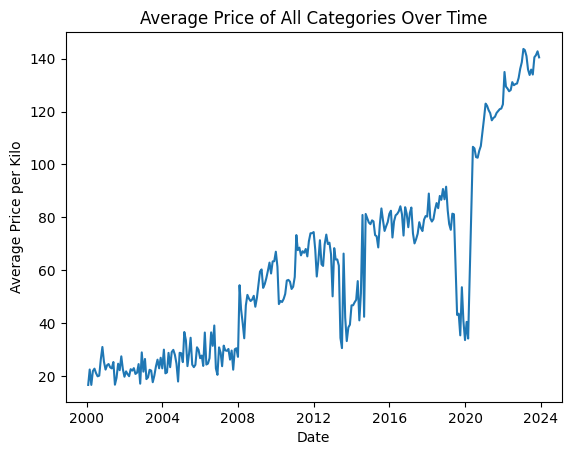

In [79]:
# Create the plot for all categories
plt.figure()  # create a new figure
sns.lineplot(x=price_resampled.index, y=price_resampled.values)

plt.xlabel('Date')
plt.ylabel('Average Price per Kilo')
plt.title('Average Price of All Categories Over Time')
plt.show()

The price is linearly increasing across time; however, we can observe slight dips in the graph, notably in 2020 when the COVID-19 pandemic started.

Now, let us plot the Time VS Price for each category.

C:\Users\WINDOWS 10\AppData\Local\Temp\ipykernel_2208\3039847819.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  category_data_resampled = category_data['price'].resample('M').mean()


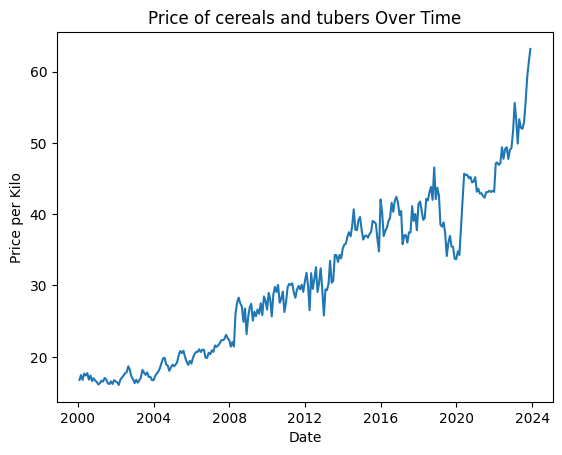

C:\Users\WINDOWS 10\AppData\Local\Temp\ipykernel_2208\3039847819.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  category_data_resampled = category_data['price'].resample('M').mean()


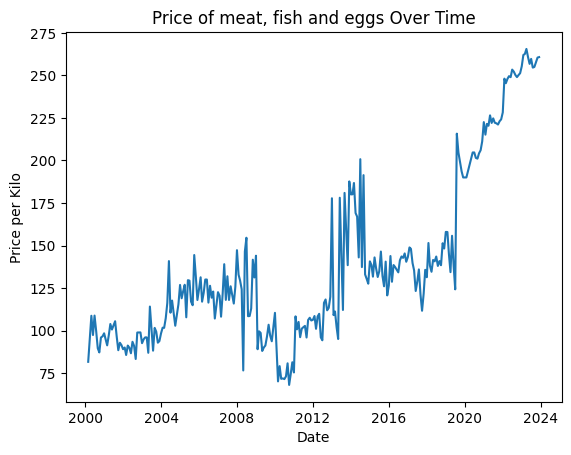

C:\Users\WINDOWS 10\AppData\Local\Temp\ipykernel_2208\3039847819.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  category_data_resampled = category_data['price'].resample('M').mean()


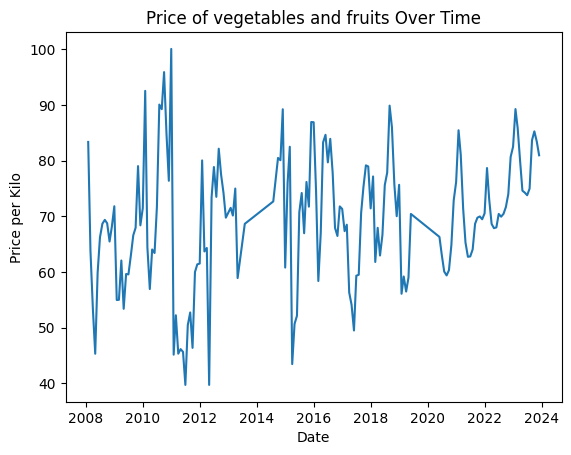

In [80]:
# Plot per category
selected_categories = ['cereals and tubers', 'meat, fish and eggs', 'vegetables and fruits']
for category in selected_categories:
    category_data = data_model_test[data_model_test['category'] == category]
    
    # Resample the data to monthly frequency for the current category
    category_data_resampled = category_data['price'].resample('M').mean()
    
    plt.figure()  # create a new figure
    sns.lineplot(x=category_data_resampled.index, y=category_data_resampled.values)
    
    plt.xlabel('Date')
    plt.ylabel('Price per Kilo')
    plt.title(f'Price of {category} Over Time')
    plt.show()

Most plots seem to follow a linear increase in price. 

## Linear Regression on Pork Data

We can create a small linear regression model for pork data only and see if it is an effective model.

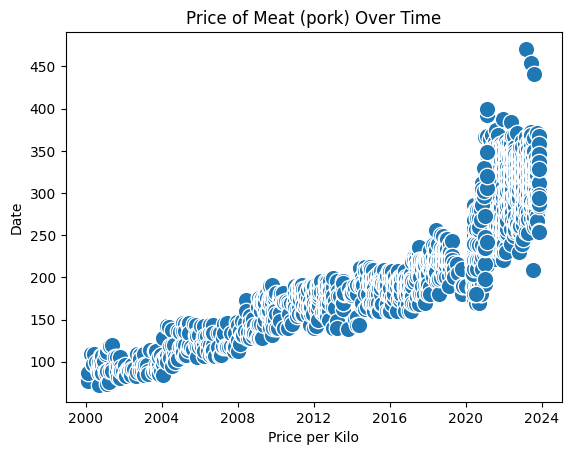

In [81]:
# @title Pork Data

# Filter rows where commodity is pork
pork = data[(data['commodity'] == 'Meat (pork)')].copy()

# Add a 'day' column with the constant value 15
pork['day'] = 15

# Create the 'date' column
pork['date'] = pd.to_datetime(pork[['year', 'month', 'day']])

# Create the scatter plot
sns.scatterplot(x=pork['date'], y=pork['price'], s=140)

plt.xlabel('Price per Kilo')
plt.ylabel('Date')
plt.title('Price of Meat (pork) Over Time')
plt.show()

Let us perform regression on the dataset to test!

In [82]:
pork.drop(['commodity', 'date'], axis=1, inplace=True)
pork

,price,region,year,month,priceflag_actual,priceflag_aggregate,pricetype_Farm Gate,pricetype_Retail,pricetype_Wholesale,day
33,77.00,5,2000,2,True,False,False,True,False,15
48,86.29,14,2000,2,True,False,False,True,False,15
80,108.71,2,2000,4,True,False,False,True,False,15
105,97.14,5,2000,5,True,False,False,True,False,15
114,97.64,11,2000,5,True,False,False,True,False,15
...,...,...,...,...,...,...,...,...,...,...
121169,306.33,4,2021,2,False,True,False,True,False,15
121198,392.00,5,2021,2,False,True,False,True,False,15
121224,400.00,6,2021,2,False,True,False,True,False,15
121366,242.33,11,2021,2,False,True,False,True,False,15


In [83]:
# Split
X = pork.drop(['price'], axis=1).values
y = pork['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Train
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict
y_pred = regressor.predict(X_test)
comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})

mse = mean_squared_error(y_test, y_pred)

display(comparison_df)
print('MAE:', mean_absolute_error(y_test,y_pred))
print('MSE:', mse)
print("RMSE:",np.sqrt(mse))
print("r2:", r2_score(y_test,y_pred))

,Actual,Predicted
0,260.86,282.494522
1,340.00,293.167281
2,215.79,232.597299
3,95.11,90.361325
4,183.28,176.604377
...,...,...
589,310.00,284.514146
590,181.82,190.153813
591,336.25,294.999286
592,180.80,260.450594


MAE: 30.379895836898655
MSE: 1411.27075371834
RMSE: 37.56688373712065
r2: 0.7587449139097634


Great, it seems that linear regression was effective for pork. Let's try it for the whole dataset.

# Model Training

In [84]:
# Split
X = data_encoded.drop(['price'], axis=1).values
y = data_encoded['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Train
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict
y_pred = regressor.predict(X_test)
comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})

mse = mean_squared_error(y_test, y_pred)

display(comparison_df)
print('MAE:', mean_absolute_error(y_test,y_pred))
print('MSE:', mse)
print("RMSE:",np.sqrt(mse))
print("r2:", r2_score(y_test,y_pred))

,Actual,Predicted
0,83.18,79.531250
1,35.00,28.441406
2,29.89,30.480469
3,93.87,88.558594
4,48.92,61.773438
...,...,...
36449,200.00,134.046875
36450,195.00,186.199219
36451,226.25,270.455078
36452,208.75,142.533203


MAE: 23.86030111150354
MSE: 1590.3111584183046
RMSE: 39.87870557601268
r2: 0.8715033443013612


In [85]:
# Save the model
jb.dump(regressor, 'commodity-predict.pkl')
jb.dump(regressor, 'app/commodity-predict.pkl')

['app/commodity-predict.pkl']

## Comparison with MLP

Next, we compare our linear regression model with an MLP regressor.

In [86]:
# from sklearn.neural_network import MLPRegressor

# # data_MLP = data_encoded.drop(['priceflag_actual', 'priceflag_aggregate', 'pricetype_Farm Gate', 'pricetype_Retail', 'pricetype_Wholesale', 'region'], axis=1)
# data_MLP=data_encoded.copy()

# # Split
# X = data_MLP.drop(['price'], axis=1).values
# y = data_MLP['price'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# # Train
# regressor_MLP = MLPRegressor(random_state=1, max_iter=200)
# regressor_MLP.fit(X_train, y_train)

# # Predict
# y_pred = regressor_MLP.predict(X_test)
# comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})

# mse = mean_squared_error(y_test, y_pred)

# display(comparison_df)
# print('MAE:', mean_absolute_error(y_test,y_pred))
# print('MSE:', mse)
# print("RMSE:",np.sqrt(mse))
# print("r2:", r2_score(y_test,y_pred))

# Results and Discussion
Our model achieved a $r^2$ value of 0.87 using linear regression, which is above the minimum percentage of 0.75. The data can, to some extent, predict the price given our input data.

Other models using linear regression had an accuracy of at least 80% up to higher than 95% on certain products. Aside from linear regression, they also used other models such as GARCH/ARCH and ARIMA. They also used smaller datasets but used more columns such as temperature and precipitation.

In comparison, our model used multiple linear regression and had and r2 score of 0.87. Compared to the existing study, our model focuses on the Philippine setting using a much larger dataset.  It is also more accessible to the common Filipino using our web app.

## Comparison to MLP

The MLP model is in a separate Python Notebook also submitted here.

Moreover, compared to the $r^2=0.86$ with the MLP regressor, the linear regression model achieved a slightly better performance. The latter is a slightly better fit for our data compared to MLP regressor.

# Recommendations

We can also analyze interplay of world events that affect economy (ie. COVID-19) and other factors such as temperature and climate. Moreover, we can also target special events such as when prices usually increase (i.e., fruits during the New Year).

Since most but not all price trends are linear, we can consider using Fourier regression for trends with high fluctuation for select categories. A more complex nonlinear model may suit other commodities that have unpredictable fluctuating price trends (decision trees, time series analysis). We can also incorporate additional features to target specific commodities.

Lastly, we can use larger datasets for a larger scope.

# Sample prediction

In [87]:
# Create a DataFrame for the new data
new_data = pd.DataFrame({
    'commodity': ['Taro'],
    'year': [2023],
    'month': [1],
    'priceflag': ['actual'],
    'pricetype': ['Retail'],
    'region': [1]
})

# One-hot encode the categorical columns
new_data_encoded = pd.get_dummies(new_data, columns=['priceflag', 'pricetype', 'commodity'])

# Make sure new_data_encoded has the same columns as data_encoded
missing_cols = set(data_encoded.columns) - set(new_data_encoded.columns)
for c in missing_cols:
    new_data_encoded[c] = 0
new_data_encoded = new_data_encoded[data_encoded.columns]

# Drop the 'price' column if it exists
if 'price' in new_data_encoded.columns:
    new_data_encoded = new_data_encoded.drop(['price'], axis=1)
new_X = new_data_encoded.values

# Use the trained model to make predictions
new_y_pred = regressor.predict(new_X)

# new_y_pred now contains the predicted price for your new data
print("The predicted price is:", new_y_pred[0])

The predicted price is: 69.3359375
